# Расчёт VaR на реальных данных

## 1. Загрузка данных и ознакомительная информация об выбранных рыночных инструментов

In [175]:
import numpy as np
import pandas as pd
import arch
import apimoex
import requests
from scipy import stats
from datetime import datetime
import yfinance as yf


import seaborn as sns
import matplotlib.pyplot as plt

Считаем для начала данные компании яндекс. Для этого воспользуеся библиотекой apimoex, который автоматически выгружает данные с Московской биржи

In [176]:
with requests.Session() as session:
    yndx = apimoex.get_board_history(session, 'YNDX', start='2017-09-30')
    yndx = pd.DataFrame(yndx)
    yndx.set_index('TRADEDATE', inplace=True)
    yndx.index = pd.to_datetime(yndx.index, format='%Y-%m-%d')

In [177]:
yndx.head()

,BOARDID,CLOSE,VOLUME,VALUE
TRADEDATE,,,,
2017-10-02,TQBR,1906.5,79811,152669880.0
2017-10-03,TQBR,1961.0,80270,156084242.5
2017-10-04,TQBR,1942.5,44684,87956429.5
2017-10-05,TQBR,1925.0,54926,106463338.5
2017-10-06,TQBR,1893.0,61115,117225632.0


In [178]:
yndx.rename(columns={'CLOSE': 'YNDX', 'VOLUME':'yndx_volume'}, inplace=True)

In [179]:
yndx.drop(['BOARDID', 'yndx_volume', 'VALUE'], axis = 1, inplace = True)

In [212]:
# Оставим только сами котировки компании
yndx.head()

,YNDX
TRADEDATE,
2017-10-02,1906.5
2017-10-03,1961.0
2017-10-04,1942.5
2017-10-05,1925.0
2017-10-06,1893.0


Теперь, с помощью специального пакета yfinance, который автоматически выгружает котировки с yahoo finance, выгрузим котировки соотношения евро к доллару и фьючерсные цены на пшеницу

In [181]:
data_currency = yf.download('EURUSD=X','2017-09-30','2022-09-30', interval='1d')
data_currency.rename(columns={'Close': 'EURUSD'}, inplace=True)
data_currency.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis = 1, inplace = True)

[*********************100%***********************]  1 of 1 completed


In [182]:
data_currency.head()

,EURUSD
Date,
2017-09-29,1.178175
2017-10-02,1.180735
2017-10-03,1.173378
2017-10-04,1.174757
2017-10-05,1.175724


In [183]:
wheat = yf.download('ZW=F','2017-09-30','2022-09-30', interval='1d')
wheat.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-09-29,455.50,459.00,446.25,448.25,448.25,93111
2017-10-02,446.50,448.50,439.50,444.75,444.75,75645
2017-10-03,445.00,450.50,443.25,448.00,448.00,81890
2017-10-04,448.75,449.25,441.50,442.00,442.00,57486
2017-10-05,443.25,444.00,438.00,440.75,440.75,57909


In [184]:
wheat.rename(columns={'Close': 'WHEAT'}, inplace=True)
wheat.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis = 1, inplace = True)

Объединим теперь все 3 таблички в одну

In [185]:
data = pd.merge(left=data_currency,
              right=wheat,
              left_index=True,
              right_index=True)

In [186]:
df = data = pd.merge(left=data,
              right=yndx,
              left_index=True,
              right_index=True)
df.index = pd.to_datetime(df.index, format='%Y-%m-%d')

df.head(5)

,EURUSD,WHEAT,YNDX
2017-10-02,1.180735,444.75,1906.5
2017-10-03,1.173378,448.00,1961.0
2017-10-04,1.174757,442.00,1942.5
2017-10-05,1.175724,440.75,1925.0
2017-10-06,1.171234,443.50,1893.0


Посмотрим теперь на графики стоимости

No handles with labels found to put in legend.


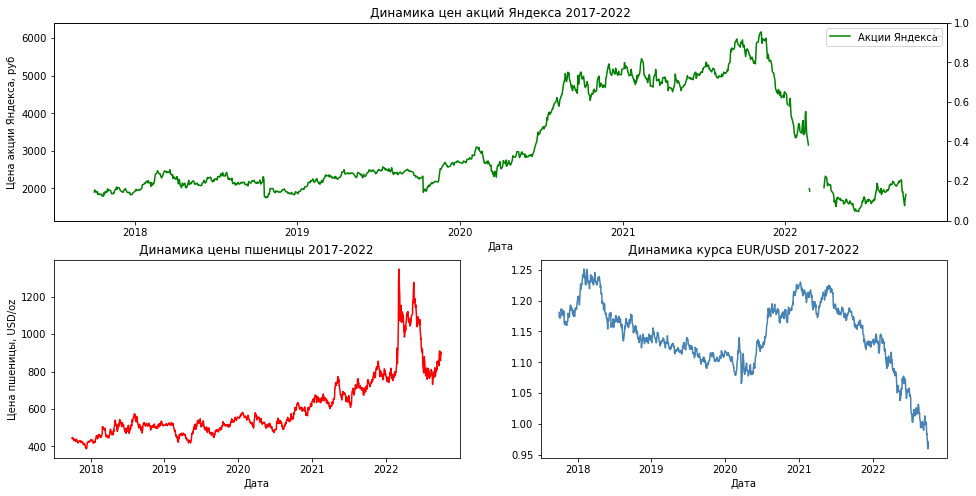

In [213]:
fig = plt.figure(figsize=(16, 8))
ax = plt.subplot2grid((2, 2), (0, 0), colspan=2)
ax2 = ax.twinx()

ax.plot(df.index, df.YNDX, color='green', label='Акции Яндекса')

ax.set_xlabel('Дата')
ax.set_ylabel('Цена акции Яндекса, руб')
ax.set_title('Динамика цен акций Яндекса 2017-2022')
ax.legend()
ax2.legend()

ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=1)
ax3.plot(df.index, df.WHEAT, color='red')
ax3.set_xlabel('Дата')
ax3.set_ylabel('Цена пшеницы, USD')
ax3.set_title('Динамика цены пшеницы 2017-2022')

ax4 = plt.subplot2grid((2, 2), (1, 1), colspan=1)
ax4.plot(df.index, df.EURUSD, color='steelblue')
ax4.set_xlabel('Дата')
ax4.set_title('Динамика курса EUR/USD 2017-2022')

plt.show();

Можно сделать несколько выводов на основе графиков:
- __Яндекс__ с 2018 по 2020 год котировался примерно на одном уровне, но с пандемии до начала спецоперации сильно вырос, но спецоперация уронила стоимость яндекса, сделав её стоимость даже ниже, чем в начале временного периода. Такая динамика прежде всего тем, что в первые 2 года временного периода, несмотря на то что Яндекс активно развивал свои продукты, на рынке ещё было относительно достаточно конкурентов, но период пандемии очень хорошо раскрыл сильные стороны компании, и многие, соблюдая самоизоляцию, пользовались сервисами яндекса (поисковик, доставка еды, просмотр кино и т.д.), из-за чего компания сильно в стоимости и становилась больше. Но во время спецоперации на компанию наложили серьёзные санкции, из-за чего стоимость компании критически упала.
- Цены на __пшеницу__ держались на разумном уровне долгое время даже в 2020 году, но в 2021 году началась сильная иныляция по всему миру, что подняло цену и на пшеницу, а с началом спецоперации цена на пшеницу очень сильно выросла из-за наршуения цепочки поставок.
- На графике видно два периода, где __евро__ ослабевал: в период с 2018 по 2020 год и с середины 2021 года по сегодняшний день. В первом случае это было связано с медленным ростом экономики ЕС в целом, когда не удавалось достигать таргета по инфляции, а во втором случае сильный эффект дал энергетический кризис, из-за чего евро отношение евро к доллару впервые стало меньше единицы

## 2. Проверка на нормальность

Прологарифмируем доходности акций, чтобы было легче интерпретировать результаты, т. к. изменения в логарифмах приблитзительно можно интерпретировать как процентное изменение

In [214]:
r = np.log(1+df.pct_change()).iloc[1:, :]
r.head()

,EURUSD,WHEAT,YNDX
2017-10-03,-0.006250,0.007281,0.028185
2017-10-04,0.001174,-0.013483,-0.009479
2017-10-05,0.000823,-0.002832,-0.009050
2017-10-06,-0.003826,0.006220,-0.016763
2017-10-09,0.002568,-0.017056,0.014162


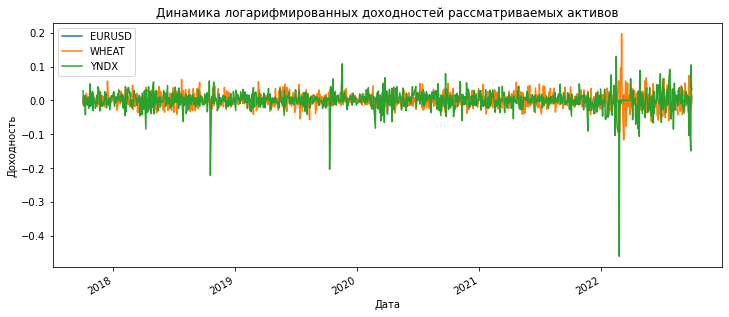

In [215]:
r.plot(title='Динамика логарифмированных доходностей рассматриваемых активов',
       xlabel='Дата',
       ylabel='Доходность',
       legend=True,
       figsize=(12, 5));

Волатильность яндекса гораздо сильнее, чем волатильность других активов. Это логично, т. к. ценные бумаги являются в принципе более рисковым инструментом, чем валюта или инструмент товарного рынка

<Figure size 1008x720 with 0 Axes>

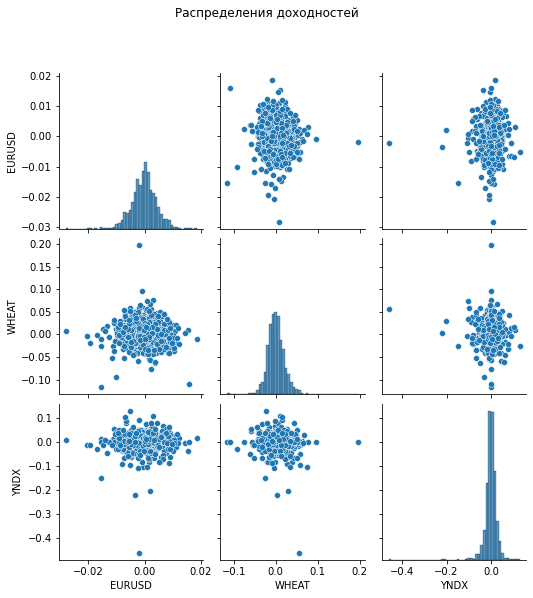

In [216]:
# Посмотрим на распределение доходностей
plt.figure(figsize=(14, 10));
g = sns.pairplot(r, diag_kws={'bins':50})
g.fig.suptitle('Распределения доходностей', y=1.1);

Ни одно из распределений не похоже на нормальное, особенно сильно это видно по Яндексу.

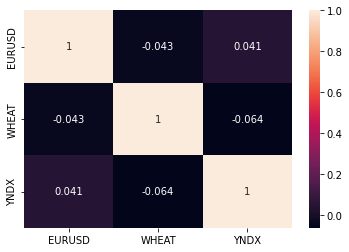

In [217]:
sns.heatmap(r.corr(), annot=True);

По крайней мере корреляции между активами не наблюдается. В принципе, уже можно сказать что распределения не являются нормальными, но на всякий случай убедимся в этом, применив формальные тесты

In [193]:
def isNormal(returns: pd.Series, series_name:str):
    ks_crit = stats.kstest(returns,'norm')[0]
    ks_pval = stats.kstest(returns,'norm')[1]
    
    out = \
    f"""
    Временной ряд: {series_name}
    ----------
    Тестовая статистика Шапиро: {stats.shapiro(returns)[0]:.3f},
    p-value: {stats.shapiro(returns)[1]:.3f} \n
    Тестовая статистика Колмогорова-Смирнова: {ks_crit:.3f}, 
    p-value: {ks_pval:.3f}"""
    return out

In [197]:
r.apply(lambda x: print(isNormal(x, x.name)))


    Временной ряд: EURUSD
    ----------
    Тестовая статистика Шапиро: 0.980,
    p-value: 0.000 

    Тестовая статистика Колмогорова-Смирнова: 0.493, 
    p-value: 0.000

    Временной ряд: WHEAT
    ----------
    Тестовая статистика Шапиро: 0.947,
    p-value: 0.000 

    Тестовая статистика Колмогорова-Смирнова: 0.473, 
    p-value: 0.000

    Временной ряд: YNDX
    ----------
    Тестовая статистика Шапиро: 0.765,
    p-value: 0.000 

    Тестовая статистика Колмогорова-Смирнова: 0.466, 
    p-value: 0.000


EURUSD    None
WHEAT     None
YNDX      None
dtype: object

Что и требовалось доказать. Нормальное распределение не стоит использоват при расчёте VaR

## 3. Исторический метод расчёта VaR

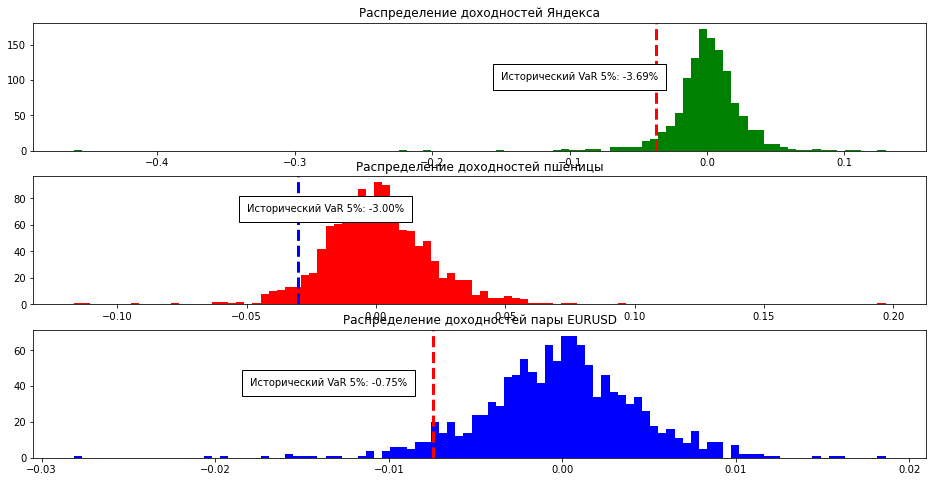

In [203]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(16, 8))

ax[0].hist(r.YNDX, color='green', bins=100)
ax[0].set_title('Распределение доходностей Яндекса')
ax[0].axvline(x=np.quantile(a=r.YNDX, q=0.05), 
              color='red', linewidth=3, linestyle='--')
ax[0].text(-0.15, 100, 
           f'Исторический VaR 5%: {np.quantile(a=r.YNDX, q=0.05)*100:.2f}%', 
           bbox={'facecolor': 'white', 'pad': 8, 'edgecolor':'black'});



ax[1].hist(r.WHEAT, color='red', bins=100)
ax[1].set_title('Распределение доходностей пшеницы')
ax[1].axvline(x=np.quantile(a=r.WHEAT, q=0.05), 
              color='blue', linewidth=3, linestyle='--')
ax[1].text(-0.05, 70, 
           f'Исторический VaR 5%: {np.quantile(a=r.WHEAT, q=0.05)*100:.2f}%', 
           bbox={'facecolor': 'white', 'pad': 8, 'edgecolor':'black'});

ax[2].hist(r.EURUSD, color='blue', bins=100)
ax[2].set_title('Распределение доходностей пары EURUSD')
ax[2].axvline(x=np.quantile(a=r.EURUSD, q=0.05), 
             color='red', linewidth=3, linestyle='--')
ax[2].text(-0.018, 40, 
           f'Исторический VaR 5%: {np.quantile(a=r.EURUSD, q=0.05)*100:.2f}%', 
           bbox={'facecolor': 'white', 'pad': 8, 'edgecolor':'black'});

plt.show();


Т. к. мы используем данные по российской компании, которые обычно бывают более волатильными, яем западные компании, то использовать короткий период будет не уместным, также не стоит брать торговый год по той же причине + быстро меняющейся конъюктуре на российском рынке. Значит, стоит взять торговое полугодие (то есть 126 дней)

In [218]:
yndx_hvar5 = r.YNDX.rolling(window=126).apply(lambda x: np.quantile(x, q=0.05)).shift(1)
wheat_hvar5 = r.WHEAT.rolling(window=126).apply(lambda x: np.quantile(x, q=0.05)).shift(1)
eurusd_hvar5 = r.EURUSD.rolling(window=126).apply(lambda x: np.quantile(x, q=0.05)).shift(1)

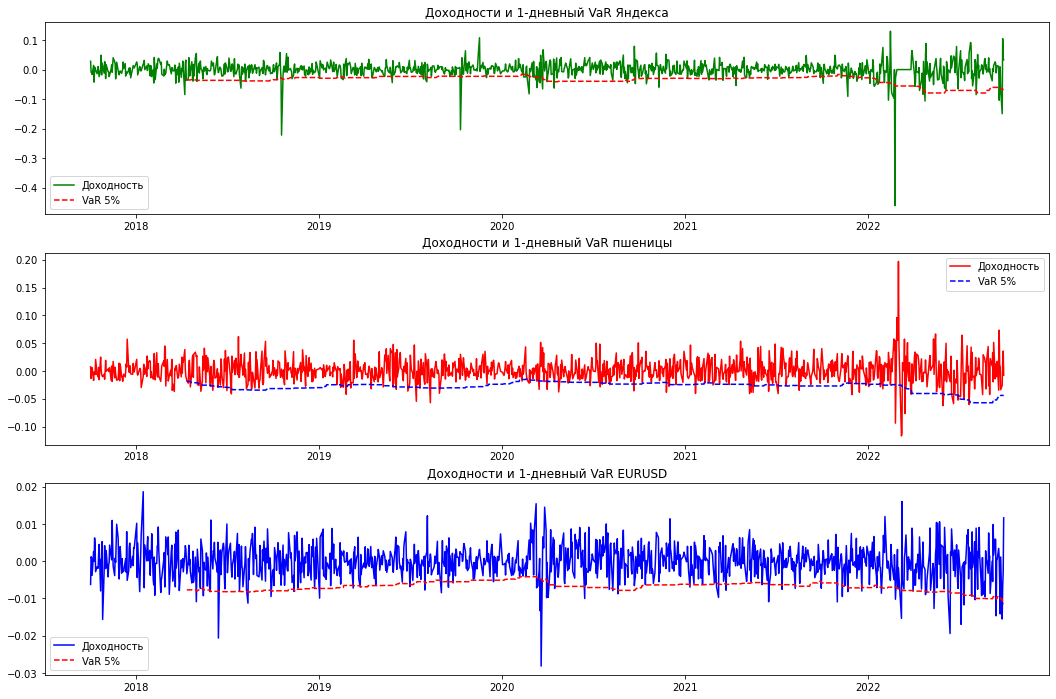

In [219]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(18, 12))

ax[0].plot(r.YNDX, color='green', label='Доходность')
ax[0].plot(yndx_hvar5, color='red', label='VaR 5%', linestyle='--')
ax[0].set_title('Доходности и 1-дневный VaR Яндекса')
ax[0].legend()

ax[1].plot(r.WHEAT, color='red', label='Доходность')
ax[1].plot(wheat_hvar5, color='blue', label='VaR 5%', linestyle='--')
ax[1].set_title('Доходности и 1-дневный VaR пшеницы')
ax[1].legend()

ax[2].plot(r.EURUSD, color='blue', label='Доходность')
ax[2].plot(eurusd_hvar5, color='red', label='VaR 5%', linestyle='--')
ax[2].set_title('Доходности и 1-дневный VaR EURUSD')
ax[2].legend()

plt.show();

Исторический тренд очень плохо улавливает общий тренд на рынке, из-за чего оценки VaR в данном случае не особо корректны. Посмотрим, как справляется параметрический метод

## 4. Параметрический метод расчёта VaR

В качестве параметрического метода возьмём GARCH(1, 1)модель. Этого будет достаточно, чтобы эффективно опистаь волатильность доходностей компании и посчитать риск. В качестве распределения случайных шоков возьмём t-распределение Стьюдента, т. к. он больше подходит для описания эмпирических распределений.

In [220]:
garch_kwargs = {'p':1, 'q':1, 
                'mean':'constant', 
                'vol':'GARCH', 'dist':'studentst'} 

In [221]:
def GARCH_fitpredict(series, horizon, **garch_kwargs):
    """
    Returns GARHC conditional volatility forecast for given series
    -----------
    Parameters:
    series - series of returns
    horizon - number of periods to forecast std
    garch_kwargs - GARCH params such as p, q, mean, vol type and error distribution
    """
    model = arch.arch_model(series*100, **garch_kwargs)
    # turn off printing estimation results
    fitted = model.fit(disp='off')
    forecast = fitted.forecast(horizon=horizon, 
                               start=series.index[-1], 
                               reindex=True)
    std_forecast = np.sqrt(forecast.variance.iloc[-1, :].values/10**4)
    if horizon==1:
        return std_forecast[0]
    return std_forecast

In [222]:
# 5% и 95% квантили для нормального распределения 
stats.norm.ppf((0.05, 0.95))


array([-1.64485363,  1.64485363])

In [223]:
def VaR(returns: pd.Series,
        method: str,
        level,
        ret_dist:str,
        garch_kwargs=None):
    """
    Returns Value at Risk for given asset returns
    ----
    Parameters:
    - method: str, historical or parametric
    - level: float in (0, 1), VaR level
    - rets: error distribution in GARCH model, 'norm' or 't' (Student)
    - garch_kwargs: GARCH model parameters for GARCH_fitpredict
    """
    
    # historical VaR calculation
    if method=='historic':
        return np.quantile(returns, level)
    # parametric VaR with GARCH forecast
    elif method=='parametric':
        # fit Student distribution to returns
        if ret_dist=='t':
            t_df, t_loc, t_scale = stats.t.fit(returns)
            crit_value = stats.t(df=t_df).ppf(level)
        else:
            crit_value = stats.norm.ppf(level)
        return crit_value * GARCH_fitpredict(returns, 
                                             horizon=1,
                                             **garch_kwargs)

In [224]:
VaR_kwargs = {x :{'method': 'parametric',
                  'level': 0.05,
                  'ret_dist': 'norm',
                  'garch_kwargs': garch_kwargs} for x in ['sber_5%',
                                                          'mgnt_5%',
                                                          'gold_5%',
                                                          'eurusd_5%']}


In [225]:
%%time
yndx_pvar5 = r.YNDX.rolling(window=126).apply(lambda x: VaR(x, **VaR_kwargs['sber_5%'])).shift(1)
wheat_pvar5 = r.WHEAT.rolling(window=126).apply(lambda x: VaR(x, **VaR_kwargs['gold_5%'])).shift(1)
eurusd_pvar5 = r.EURUSD.rolling(window=126).apply(lambda x: VaR(x, **VaR_kwargs['eurusd_5%'])).shift(1)

C:\Users\samir\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09924. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\samir\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09919. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\samir\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleW

Wall time: 12min 20s


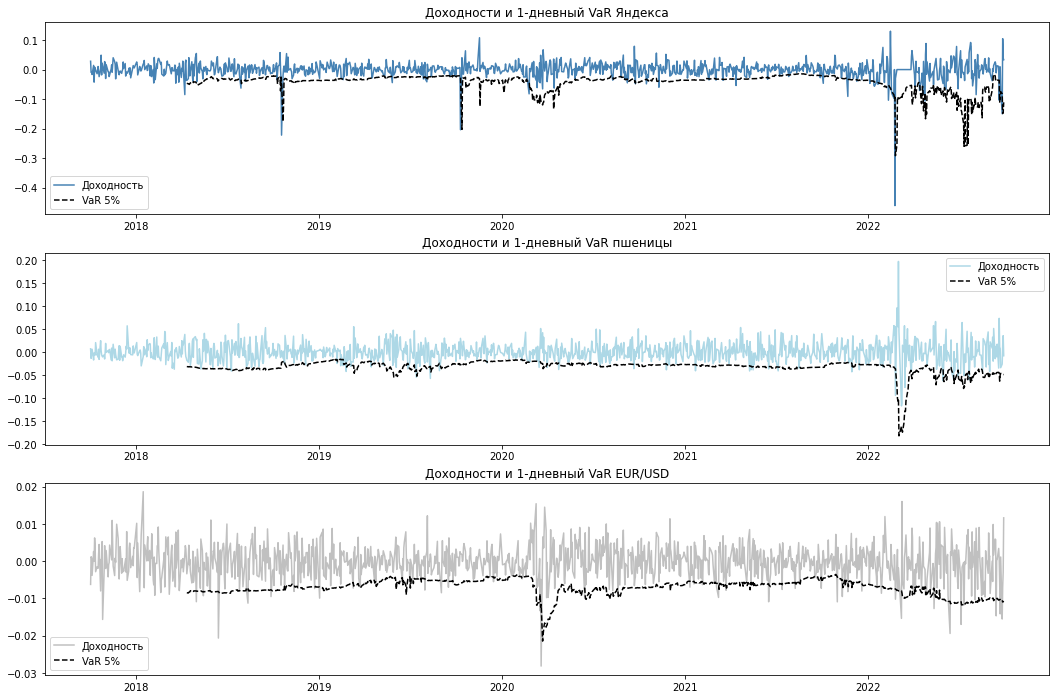

In [226]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(18, 12))

ax[0].plot(r.YNDX, color='steelblue', label='Доходность')
ax[0].plot(yndx_pvar5, color='k', label='VaR 5%', linestyle='--')
ax[0].set_title('Доходности и 1-дневный VaR Яндекса')
ax[0].legend()


ax[1].plot(r.WHEAT, color='lightblue', label='Доходность')
ax[1].plot(wheat_pvar5, color='k', label='VaR 5%', linestyle='--')
ax[1].set_title('Доходности и 1-дневный VaR пшеницы')
ax[1].legend()

ax[2].plot(r.EURUSD, color='silver', label='Доходность')
ax[2].plot(eurusd_pvar5, color='k', label='VaR 5%', linestyle='--')
ax[2].set_title('Доходности и 1-дневный VaR EUR/USD')
ax[2].legend()

plt.show();

Парамтрический метод лучше описывает доходности активов, улавливая все необходимые тренды. Исключентем являются пандемийный 2020 год для отношения евро к доллару и 2022 год для отношения евро к доллару и для яндекса 
(для фьючерсной цены пшеницы всё хорошо). Это объяняется тем, что пандемию предсказать никто не смог, и в принципе её вероятность достаточно мала, но, как говорилось ранее, для яндекса это наоборот пошло в пользу, а урожай пшеницы в том году был достаточно хорошим и собирают её обычно в середине-конце лета, а к тому моменту уже не было столь жёсткого локдауна, как в марте-мае, и мир потихоньку открывался, что позволило наладить поставки пшеницы. В 2022 же году такие просадки из-за беспрецедентных санкицй на Россию (и на Яндекс в частности) и на серьёзный энергетический кризис в Европе вследствие этих санкций.

При этом слепо доверять результатам параметрического метода не стоит, т. к. он может быть логически неверным. Для этого надо проверить её на точность. Точность параметрической модели можно установить с помощью теста Купика. Он проверяет, совпадает ли число пробитий (ситуация, когда реальная доходность меньше VaR) с ожидаемым.

Нулевая гипотеза заключается в верности VaR оценки. Проверим справедливость этого для найденых ранее значений VaR при 5% уровне значимости.

In [227]:
def kupiec_test(returns, var, series_name:str, conflevel=0.05):
    """
    Parameters:
    - returns: series of returns
    - var: series of Value at Risk estimates
    - conflevel: VaR level
    """
    L = len(returns)
    K = sum(returns < var)
    a0 = K/L
    S = 2*np.log( ((1-a0)**(L-K)) * (a0**K) ) - 2*np.log( ((1-conflevel)**(L-K)) * (conflevel**K) )
    pval = 1 - stats.chi2.cdf(S, df=1) 
    print(
    f"""
    Тест Купика для {series_name}. 
    ---------------------------------------
    Доля пробитий VaR в выборке: {a0:.3f}
    Ожидаемая доля пробитий: {conflevel:.3f}
    P-value тестовой статистики: {pval:.2f}
    ---------------------------------------
    """)

In [229]:
kupiec_test(r.YNDX, yndx_pvar5, series_name='VaR акций Яндекса', conflevel=0.05)
kupiec_test(r.WHEAT, wheat_pvar5, series_name='VaR пшеницы', conflevel=0.05)
kupiec_test(r.EURUSD, eurusd_pvar5, series_name='VaR EUR/USD', conflevel=0.05)


    Тест Купика для VaR акций Яндекса. 
    ---------------------------------------
    Доля пробитий VaR в выборке: 0.041
    Ожидаемая доля пробитий: 0.050
    P-value тестовой статистики: 0.15
    ---------------------------------------
    

    Тест Купика для VaR пшеницы. 
    ---------------------------------------
    Доля пробитий VaR в выборке: 0.040
    Ожидаемая доля пробитий: 0.050
    P-value тестовой статистики: 0.08
    ---------------------------------------
    

    Тест Купика для VaR EUR/USD. 
    ---------------------------------------
    Доля пробитий VaR в выборке: 0.052
    Ожидаемая доля пробитий: 0.050
    P-value тестовой статистики: 0.76
    ---------------------------------------
    


Для всех активов тест не отвергает нулевую гипотезу, то есть параметрический метод верно считает риски.

# 5. Оценка RAROC

In [234]:
def ear(series:pd.Series, type='historic'):
    if type=='historic':
        return series[series<0].median()
    return series[series<0].mean()

In [236]:
r['yndx_ear_hist'] = r.YNDX.rolling(window=126).apply(lambda x: ear(x))
r['yndx_ear_param'] = r.YNDX.rolling(window=126).apply(lambda x: ear(x, 'parametric'))
r['wheat_ear_hist'] = r.WHEAT.rolling(window=126).apply(lambda x: ear(x))
r['eurusd_ear_hist'] = r.EURUSD.rolling(window=126).apply(lambda x: ear(x))
r['wheat_ear_param'] = r.WHEAT.rolling(window=126).apply(lambda x: ear(x, 'parametric'))
r['eurusd_ear_param'] = r.EURUSD.rolling(window=126).apply(lambda x: ear(x, 'parametric'))

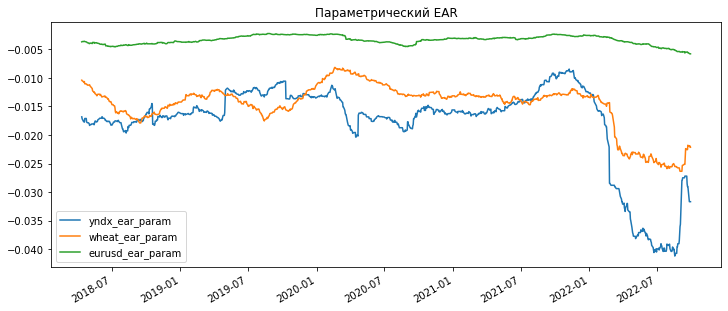

In [237]:
ear_p_cols = [x for x in r.columns if 'ear_param' in x]
r[ear_p_cols].plot(figsize=(12, 5), title='Параметрический EAR');

In [230]:
r['yndx_VaR_5_param'] = yndx_pvar5
r['yndx_VaR_5_hist'] = yndx_hvar5
r['wheat_VaR_5_param'] = wheat_pvar5
r['eurusd_VaR_5_param'] = eurusd_pvar5
r['wheat_VaR_5_hist'] = wheat_hvar5
r['eurusd_VaR_5_hist'] = eurusd_hvar5

In [238]:
r['yndx_raroc_hist'] = (r.YNDX-r.yndx_ear_hist)/r.yndx_VaR_5_hist
r['yndx_raroc_param'] = (r.YNDX-r.yndx_ear_param)/r.yndx_VaR_5_param
r['wheat_raroc_hist'] = (r.WHEAT-r.wheat_ear_hist)/r.wheat_VaR_5_hist
r['eurusd_raroc_hist'] = (r.EURUSD-r.eurusd_ear_hist)/r.eurusd_VaR_5_hist
r['wheat_raroc_param'] = (r.WHEAT-r.wheat_ear_param)/r.wheat_VaR_5_param
r['eurusd_raroc_param'] = (r.EURUSD-r.eurusd_ear_param)/r.eurusd_VaR_5_param

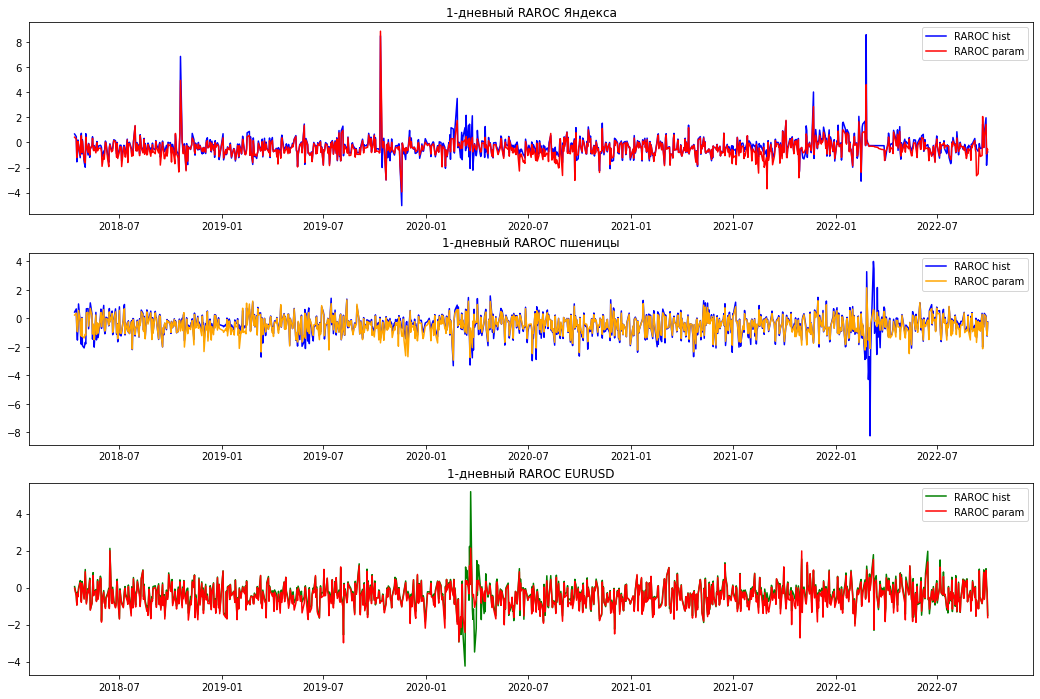

In [239]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(18, 12))

ax[0].plot(r.yndx_raroc_hist, color='blue', label='RAROC hist')
ax[0].plot(r.yndx_raroc_param, color='red', label='RAROC param')
ax[0].set_title('1-дневный RAROC Яндекса')
ax[0].legend()

ax[1].plot(r.wheat_raroc_hist, color='blue', label='RAROC hist')
ax[1].plot(r.wheat_raroc_param, color='orange', label='RAROC param')
ax[1].set_title('1-дневный RAROC пшеницы')
ax[1].legend()

ax[2].plot(r.eurusd_raroc_hist, color='green', label='RAROC hist')
ax[2].plot(r.eurusd_raroc_param, color='red', label='RAROC param')
ax[2].set_title('1-дневный RAROC EURUSD')
ax[2].legend()

plt.show();

In [240]:
r.to_csv('risk_metrics2.csv')